# Bayesian Parameter Estimation for Market Impact Models

In [1]:
# Import libraries
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import arviz as az
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on Arviz v{}'.format(az.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5
Running on Arviz v0.12.0


## Project Overview

The goal of this project is to implement a robust Bayesian inferrence routine to estimate the parameters for market impact models.  These models play a key role in the modern financial system, since they forecast how trading activity can affect the price of a stock.  For example, it is well known that if you purchase sufficient amounts of a stock, you will push the price up (similarly, selling sufficient amounts of a stock will push the price down).  Market impact models are used to provide an estimate of roughly how much our trade will push the price up or down.  Hence, many financial institutions use these models to decide the pace at which they execute transactions.

While this project is meant to cover a wide range of impact models, we will begin with the Gatheral model.

### Gatheral Impact Model

The Gatheral impact model (2010) is a simple but powerful model of trade impact in the stock market.  The model consists of an instantaneous impact term and a propagator kernel, hence it belongs to the propagator class of impact models.  The integral form of the Gatheral impact model is,

$$ S_t = S_0 + \int\limits_0^t \epsilon_n x_n^\delta \frac{1}{\left( t-n \right)^\gamma} \text{dn} $$

where,
- $S_t$ is the stock price at time $t$
- $S_0$ is the stock price at the start of the transaction
- $\epsilon_n$ is the sign of the $n$-th order, where Sell orders are $-1$ and Buy orders are $+1$
- $x_n$ is the size (number of shares) of the $n$-th order
- $\delta$ is the instantaneous impact exponent, which determines the magnitude of price change caused immediately after the $n$-th trade
- $\gamma$ is the propagator decay exponent, which determines how impact decays and the stock price recovers towards $S_0$ with time

For simplicity, we will frame the impact as the change in stock price, rather than the stock price itself.  Thus, $S_0 = 0$ and $S_t$ is the change in stock price at time $t$.  An implementation of the Gatheral model in its integral form, approximated as a discrete sum, is shown below.

In [2]:
"""
Integral (discrete sum) form of the Gatheral Model

Arguments:
'params' is a dictionary containing the values of 'delta' and 'gamma'
'arrschedule' is a 1D numpy array of length [t] containing our scheduled market trades

Returns:
'St' is a float representing the change in stock price from time 0 to t
"""
def discGatheral(params, arrschedule):
    St = np.sum(np.array([(arrschedule[n]**params['delta'])/(len(arrschedule)-n)**params['gamma'] for n in range(len(arrschedule))]))
    return St

# Example
trades = [100, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # We make a trade of 100 shares at only time t=0
gparams = {'delta': 0.5, 'gamma': 0.5}
print('Gatheral Impact Model')
print('Number of shares traded at each timestep: {}'.format(trades))
print('Impact on stock price after {} timesteps: {} %'.format(len(trades), discGatheral(gparams, trades)))

Gatheral Impact Model
Number of shares traded at each timestep: [100, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Impact on stock price after 10 timesteps: 3.162277660168379 %


This function produces a floating point estimate of the trade impact at time=t.  However, it is more interesting to view the profile of the impact.  That is, how the trade impact evolves with time.  To do so, we can simply take a slice of our orders up to each timestep and store each impact in an array, as implemented in the function below.

In [3]:
"""
Function to produce an impact profile in time for an arbitrary impact model

Arguments:
'model' is an impact model function that takes exactly two arguments (params, arrschedule) and returns exactly one argument (impact)
'params' is a dictionary containing the values of 'delta' and 'gamma'
'arrschedule' is a 1D numpy array of length [t] containing our scheduled market trades

Returns:
'impactprofile' is a 1D numpy array of length [t] containing the change in stock price at each timestep during (and after) our trades
"""
def profile(model, params, arrschedule):
    impactprofile = np.zeros(len(arrschedule))
    for t in range(len(arrschedule)):
        impactprofile[t] += model(params, arrschedule[:t])  # The impact at time t
    return impactprofile

Then, for a single trade of size=100shares, our impact profile is as shown below.

Gatheral Model
Instantaneous impact exponent: 0.5
Impact decay exponent: 0.5

Number of shares traded at each timestep: [100, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Impact on stock price after 10 timesteps: 3.162277660168379 %


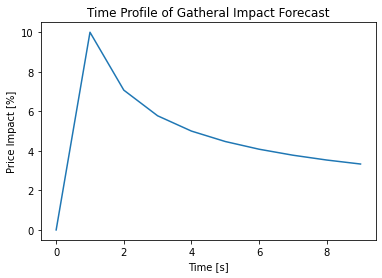

In [4]:
"""
Demonstration of the Gatheral Model for a single trade
"""
trades = [100, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # We make a trade of 100 shares at only time t=0
gparams = {'delta': 0.5, 'gamma': 0.5}

# Print summary
print('Gatheral Model')
print('Instantaneous impact exponent: {}'.format(gparams['delta']))
print('Impact decay exponent: {}\n'.format(gparams['gamma']))
print('Number of shares traded at each timestep: {}'.format(trades))
print('Impact on stock price after {} timesteps: {} %'.format(len(trades), discGatheral(gparams, trades)))

# Plot impact profile
plt.plot(range(len(trades)), profile(discGatheral, gparams, trades))
plt.xlabel('Time [s]')
plt.ylabel('Price Impact [%]')
plt.title('Time Profile of Gatheral Impact Forecast')
plt.show()

As can be seen in the figure above, the instantaneous impact of our 100share trade was to move the stock price by 10%.  Over time, the impact of our trade dissipates, creating the shape of the above graph.  If multiple trades are made over the observation time, their impacts at each timestep add up, as shown in the demonstration below.

Gatheral Model
Instantaneous impact exponent: 0.5
Impact decay exponent: 0.5

Number of shares traded at each timestep: [100, 100, 100, 100, 100, 0, 0, 0, 0, 0]
Impact on stock price after 10 timesteps: 17.89327253416535 %


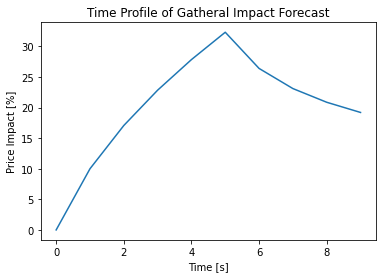

In [5]:
"""
Demonstration of the Gatheral Model for a multiple trades
"""
trades = [100, 100, 100, 100, 100, 0, 0, 0, 0, 0]  # We make a trade of 100 shares at only time t=0,1,2,3,4
gparams = {'delta': 0.5, 'gamma': 0.5}

# Print summary
print('Gatheral Model')
print('Instantaneous impact exponent: {}'.format(gparams['delta']))
print('Impact decay exponent: {}\n'.format(gparams['gamma']))
print('Number of shares traded at each timestep: {}'.format(trades))
print('Impact on stock price after {} timesteps: {} %'.format(len(trades), discGatheral(gparams, trades)))

# Plot impact profile
plt.plot(range(len(trades)), profile(discGatheral, gparams, trades))
plt.xlabel('Time [s]')
plt.ylabel('Price Impact [%]')
plt.title('Time Profile of Gatheral Impact Forecast')
plt.show()

Although the case of multiple trades (shown above) is more interesting for real world applications, for now we will only be focusing on the case of single trades.  Also, we are interested in fitting the impact model accross many different trade sizes (volumes), so the trade schedule will be like that defined in the function below.

In [6]:
"""
Function to make simulated order schedules matrix

Arguments:
'volumes' is a 1D numpy array of length v that stores the volume of each trade schedule
'timesteps' is an int representing t, the length of the observation
'disp' is a boolean that determines whether the function should print out its steps

Returns:
'schedule' is a [v X t] dimensional matrix with rows as volumes and columns as timesteps
"""
def make_sched(volumes, timesteps, disp=False):
    schedule = np.array([[v]+[0 for i in range(timesteps-1)] for v in volumes])  # Single-order trade schedule
    if disp==True:  # User wants to display what is going on
        print('Order Schedule [schedule]:\n{}\n'.format(schedule))
    return schedule

# Example
print('Single trades for volumes ranging from 100shares to 900shares:')
print(make_sched(volumes=np.arange(100, 1000, 100), timesteps=10))

Single trades for volumes ranging from 100shares to 900shares:
[[100   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0]
 [300   0   0   0   0   0   0   0   0   0]
 [400   0   0   0   0   0   0   0   0   0]
 [500   0   0   0   0   0   0   0   0   0]
 [600   0   0   0   0   0   0   0   0   0]
 [700   0   0   0   0   0   0   0   0   0]
 [800   0   0   0   0   0   0   0   0   0]
 [900   0   0   0   0   0   0   0   0   0]]


That is, instead of producing an impact curve as shown in the demonstration graphs, we are interested in producing an impact surface.  The function to calculate such a surface, as well a function for graphing it, are shown below.

In [7]:
"""
Function to produce an impact surface for an arbitrary impact model

Arguments:
'model' is an impact model function that takes exactly two arguments (params, arrschedule) and returns exactly one argument (impact)
'params' is a dictionary containing the values of 'delta' and 'gamma'
'schedule' is a [v X t] dimensional matrix of trades with rows as volumes and columns as timesteps

Returns:
'impactsurface' is a [v X t] dimensional matrix of impact with rows as volumes and columns as timesteps
"""
def surface(model, params, schedule):
    impactsurface = np.zeros(schedule.shape)
    for i in range(len(schedule)):
        impactsurface[i] = profile(discGatheral, params, schedule[i])
    return impactsurface

In [8]:
"""
Function to graph impact surfaces

Arguments:
'surfaces' is a dictionary of impact surfaces containing [v X t] dimensional matrices of impact with rows as volumes and columns as timesteps
'data' is a dictionary of emperical impact data containing [v X t] dimensional matrices of impact with rows as volumes and columns as timesteps
'schedule' is a [v X t] dimensional matrix of trades with rows as volumes and columns as timesteps
'line' is a boolean that determines whether to plot 'data' as a line graph
'title' is a string that will be set as the title of the plot

Returns:
None, but outputs a 3D plot of the impact
"""
def graph_impact(surfaces, data, schedule, line=False, title=''):
    vol_axis = np.array([schedule[:,0]]).T  # Axis for trade sizes
    fig = plt.figure(figsize=[10,10])
    ax = plt.axes(projection='3d')
    if not isinstance(surfaces, type(None)):
        for key in surfaces.keys():
            ax.plot_surface(vol_axis, np.arange(len(schedule[0])), surfaces[key], label=key)
    
    if not isinstance(data, type(None)):
        if line==True:  # User wants to plot impact as a line graph
            for key in data.keys():
                for i, obs in enumerate(data[key]):
                    data_times = np.arange(len(schedule[0]))  # Time axis
                    data_vols = np.dot(vol_axis[i], np.ones([1, len(schedule[0])]))
                    ax.plot(data_vols, data_times, obs, label='Observation')
        else:  # User wants to plot impact as a scatterplot
            for key in data.keys():
                data_times = [np.arange(len(schedule[0]))]*len(schedule)
                data_vols = np.dot(vol_axis, np.ones([1, len(schedule[0])]))
                ax.scatter(data_vols, data_times, data[key], color='red', label='Observation')
                
    ax.set_xlabel('Trade Size [no. of shares]')
    ax.set_ylabel('Time [s]')
    ax.set_zlabel('Impact [%]')
    ax.set_title(title)

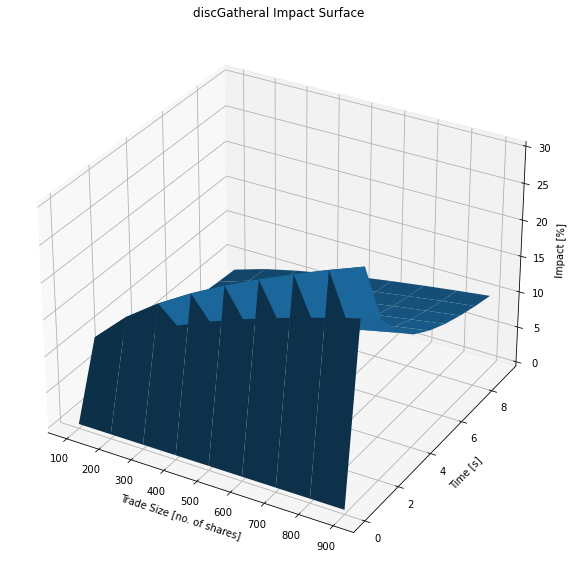

In [9]:
"""
Example of a Gatheral impact surface
"""
many_vols_trades = make_sched(volumes=np.arange(100, 1000, 100), timesteps=10)
graph_impact(surfaces={'demo':surface(discGatheral, gparams, many_vols_trades)}, 
             data=None, 
             schedule=many_vols_trades, 
             line=False, title='discGatheral Impact Surface')

## Parameter Estimation with PyMC3

Now, on to the task of parameter estimation.  The PPL language that I am using is PyMC3, though I am quite new to it and can't seem to figure out some of its quirks.  Most notably, it seems that we are unable to use loops during PyMC3 sampling, so all operations must be defined as matrix operations.  Also, it seems that some numpy linalg operations (such as tril) don't work properly in PyMC3.  Thus, in order to produce an impact surface for the Gatheral model, we must redefine the model as below.

### Gatheral Model (Again)

We now define the Gatheral model in its matrix form:

$$\text{impact} = \left( \left( g \odot \text{mask} \right) \cdot(f^T) \right)^T $$

where $f$ and $g$ are the impact and decay functions respectively.

$$f = \epsilon_n x_n^\delta$$

$$g = \frac{1}{\left( t-n \right)^\gamma}$$

In [10]:
"""
Matrix form of the Gatheral impact model

Arguments:
'params' is a dictionary containing the values of 'delta' and 'gamma'
'schedule' is a [v X t] dimensional matrix of trades with rows as volumes and columns as timesteps

Returns:
'impact' is a [v X t] dimensional matrix of impact with rows as volumes and columns as timesteps
"""
def matGatheral(params, schedule, tmat, mask):
    f = schedule**params['delta']  # Instantaneous impact function
    f = f.T
    g = 1/(tmat**params['gamma'])  # Impact decay function
    g = g*mask  # Keep lower triangle, this step is to avoid divisions by zero in the previous line
    impact = g.dot(f)  # Gatheral impact function
    impact = impact.T  # Reshape so that each row represents a trade volume and each column represents the impact at a timestep
    return impact

As seen in the function above, we now have the addition of a time matrix (tmat) and lower triangle mask (mask), which replaces the loops we had in the profile funciton.  These extra matrices can be generated by the function below.

In [11]:
"""
Function to make the time matrix and mask
"""
def make_tmat(timesteps, disp=False):
    tmat = np.array([[np.abs(i) for i in range(0-j, timesteps-j)] for j in range(timesteps)]) + np.identity(timesteps)
    lmask = np.tril(np.ones([len(tmat), len(tmat)]), -1)  # Lower triangle mask
    if disp==True:  # User wants to display what is going on
        print('Time Matrix [tmat]:\n{}\nTime Mask [lmask]:\n{}\nExpected Use [tmat⊙lmask]:\n{}\n'.format(tmat, lmask, tmat*lmask))
    return tmat, lmask

# Example
tmatrix, mask = make_tmat(timesteps=10, disp=True)

Time Matrix [tmat]:
[[1. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [1. 1. 1. 2. 3. 4. 5. 6. 7. 8.]
 [2. 1. 1. 1. 2. 3. 4. 5. 6. 7.]
 [3. 2. 1. 1. 1. 2. 3. 4. 5. 6.]
 [4. 3. 2. 1. 1. 1. 2. 3. 4. 5.]
 [5. 4. 3. 2. 1. 1. 1. 2. 3. 4.]
 [6. 5. 4. 3. 2. 1. 1. 1. 2. 3.]
 [7. 6. 5. 4. 3. 2. 1. 1. 1. 2.]
 [8. 7. 6. 5. 4. 3. 2. 1. 1. 1.]
 [9. 8. 7. 6. 5. 4. 3. 2. 1. 1.]]
Time Mask [lmask]:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]
Expected Use [tmat⊙lmask]:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 1. 0. 0. 0. 0. 0. 0. 0.]
 [4. 3. 2. 1. 0. 0. 0. 0. 0. 0.]
 [5. 4. 3. 2. 1. 0. 0. 0. 0. 0.]
 [6. 5. 4. 3. 2. 1. 0. 0. 0. 0.]
 [7. 6. 5. 4. 3. 2. 1. 0. 0. 0.]
 [8. 7. 

We can show that matGatheral produces the same result as the sureface we had with discGatheral.

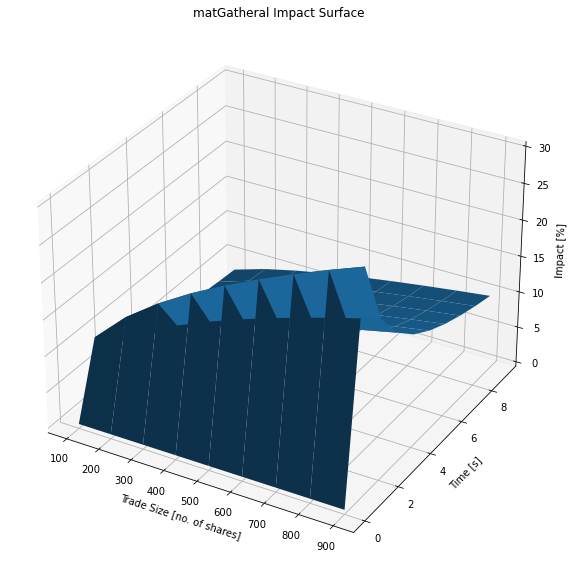

In [12]:
"""
Example of a Gatheral impact surface produced with matGatheral
"""
graph_impact(surfaces={'demo':matGatheral(gparams, many_vols_trades, tmatrix, mask)},
             data=None, 
             schedule=many_vols_trades, 
             line=False, title='matGatheral Impact Surface')

### Data Generation

While I have access to empirical data, it is quite useful to see if the function works with simulated data (over which we have full control of the parameters).  To make the simulated data challenging, we first simulate an imbalance in data collection.  That is, we will have more data for some trade sizes than others because they occur more frequently.  (It tends to be the case that smaller trades occur more frequently than larger trades).

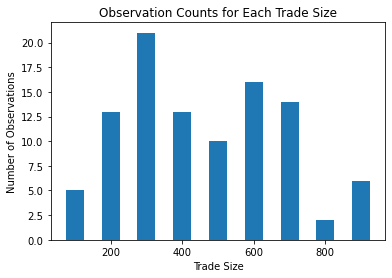

In [13]:
"""
Make an imbalanced collection of trade observations
"""
tmatrix, mask = make_tmat(timesteps=10, disp=False)
vols = np.arange(100, 1000, 100)
probs = np.abs(np.random.normal(loc=0, scale=1.0, size=vols.shape))  # Probabilities of each trade occuring
probs = probs/np.sum(probs)  # Normalize probabilities
nobs = 100  # Number of observations
tradeschedule = make_sched(volumes=np.random.choice(vols, size=nobs, p=probs), timesteps=len(tmatrix), disp=False)

# Plot the observation counts for each volume
plt.bar(vols, np.array([tradeschedule[tradeschedule==v].shape[0] for v in vols]), width=50)
plt.xlabel('Trade Size')
plt.ylabel('Number of Observations')
plt.title('Observation Counts for Each Trade Size')
plt.show()

Next, it is important to include some noise in our data.  Since we are generating our own data to be fitted to the Gatheral model, a Gatheral model with known priors will be used to generate our data.  Also, the output of the impact generated by our known Gatheral model will be scrambled again with a numpy random function.  The result is noisy data, as shown below.

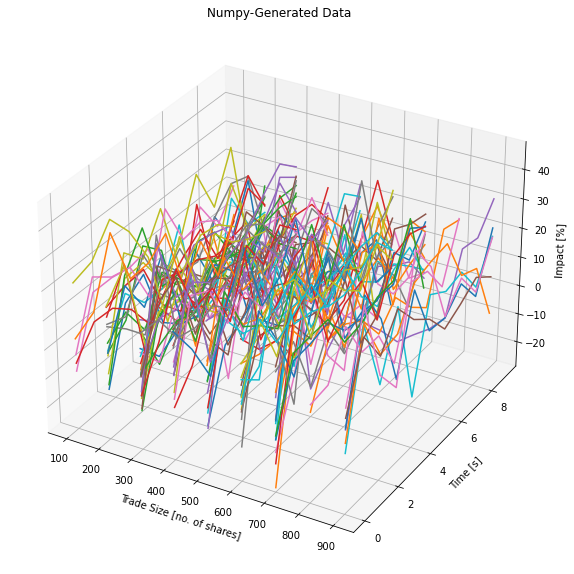

In [14]:
"""
Produce simulated noisy data for the Gatheral impact model
"""
trueparams = {'delta': 0.5, 'gamma': 0.5}
noisyparams = {'delta': np.abs(np.random.normal(loc=trueparams['delta'], scale=0.1)),
               'gamma': np.abs(np.random.normal(loc=trueparams['gamma'], scale=0.1))}

observations = np.random.normal(
    loc=matGatheral(trueparams, tradeschedule, tmatrix, mask),
    scale=10
)
graph_impact(surfaces=None, schedule=tradeschedule, data={'obs':observations}, line=True, title='Numpy-Generated Data')

### Estimation

Finally, we estimate the parameters $\delta$ and $\gamma$ using Bayesian inference.  If this process goes well, we should recover something similar to the priors we used to generate the data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, gamma, delta]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
delta     0.485  0.008   0.471    0.499      0.000    0.000    1676.0   
gamma     0.466  0.041   0.390    0.541      0.001    0.001    1593.0   
epsilon  10.359  0.236   9.943   10.833      0.005    0.003    2704.0   

         ess_tail  r_hat  
delta      1840.0    1.0  
gamma      1868.0    1.0  
epsilon    2068.0    1.0  


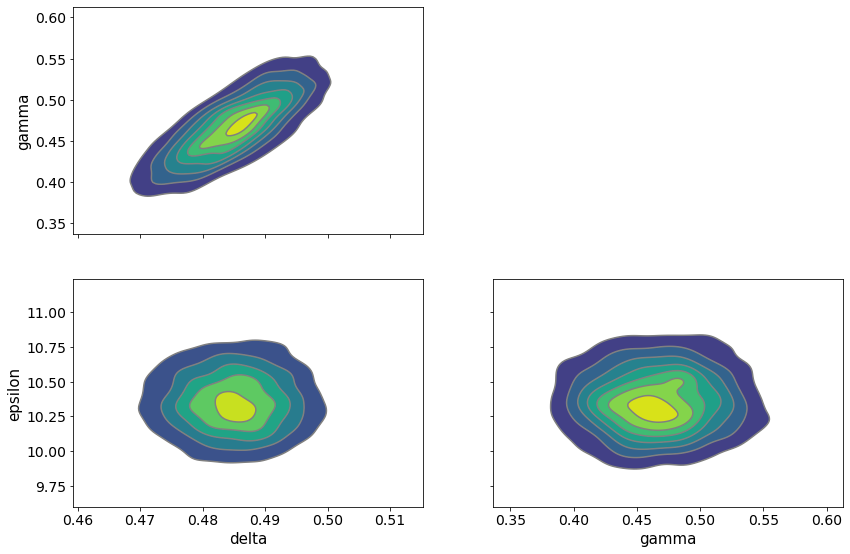

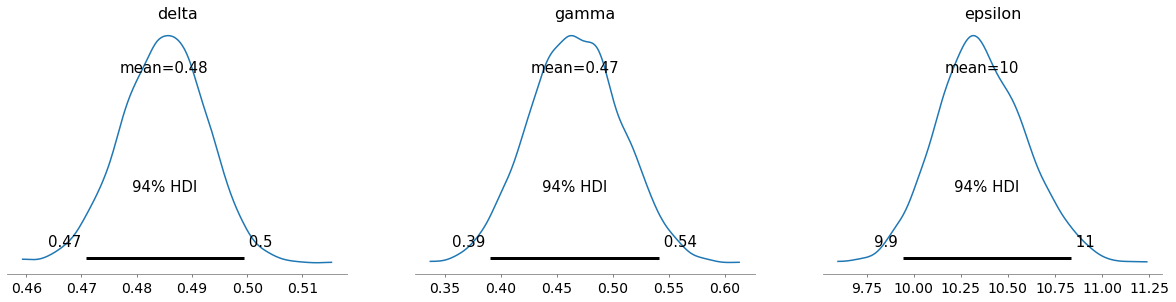

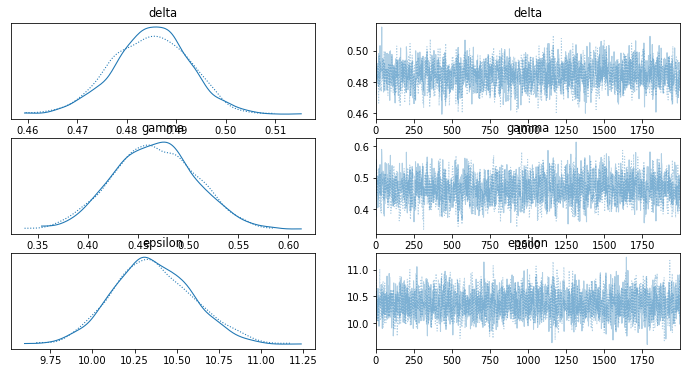

In [16]:
"""
Estimate parameters using Bayesian inference
"""
with pm.Model() as reg_model:
    # Uninformed priors for unknown model parameters
    priors = {'delta': pm.Uniform('delta', 0.1, 3.0), 'gamma': pm.Uniform('gamma', 0.1, 3.0)}
    epsilon = pm.HalfNormal('epsilon', (observations-observations.mean(axis=0)).std())
    
    # Mean value of outcome
    mu = matGatheral(priors, tradeschedule, tmatrix, mask)
    
    # Likelihood of observations
    pred = pm.Normal('pred', mu, sd=epsilon, observed=observations)
    
    # Explore the parameter space
    infdat = pm.sample(2000, tune=2000, return_inferencedata=True, cores=1)
    print(az.summary(infdat))
    az.plot_pair(infdat, kind='kde')
    az.plot_posterior(infdat)
    az.plot_trace(infdat)